<a href="https://colab.research.google.com/github/KaiKevinLiao/Econ-613-Assignment/blob/main/tensor_distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.stats import rv_continuous
import matplotlib.pyplot as plt

# Define distribution of beta by subclassing rv_continuous
class CustomDistribution(rv_continuous):
    """
    Distribution of beta
    """
    def _pdf(self, x, a, b):

        return np.exp(-(x - a)**2 / (2 * b**2)) / (b * np.sqrt(2 * np.pi))

    # def _cdf(self, x, a, b):

    #     return None


class TransformedDistribution(rv_continuous):
    """
    Distribution of V(beta), transformed from the distribution of beta.
    """
    def __init__(self, beta_dist, a, b, **kwargs):
        super(TransformedDistribution, self).__init__(**kwargs)
        self.beta_dist = beta_dist
        self.a = a
        self.b = b

    def _pdf(self, x):
        # Apply a linear transformation to the PDF of the custom distribution
        return self.beta_dist.pdf((x - self.a) / self.b) / self.b

In [ ]:
Beta = CustomDistribution(0, 1)
V = TransformedDistribution(Beta, 0, 1)

In [ ]:
V.cdf(0.5)

TypeError: ignored

In [1]:
import numpy as np
from scipy.stats import rv_continuous
import matplotlib.pyplot as plt

# Define a custom distribution by subclassing rv_continuous
class CustomDistribution(rv_continuous):
    def _pdf(self, x):
        # Define the probability density function (PDF) of your distribution
        return np.exp(-x**2)

# Define a new distribution as a linear transformation of the custom distribution
class TransformedDistribution(rv_continuous):
    def __init__(self, custom_dist, a, b, **kwargs):
        self.custom_dist = custom_dist
        self.a = a
        self.b = b

    def _pdf(self, x):
        # Apply a linear transformation to the PDF of the custom distribution
        return self.custom_dist.pdf((x - self.a) / self.b) / self.b

    def _parse_args(self, *args, **kwds):
        # Explicitly call the _parse_args method from the rv_continuous superclass
        return super(TransformedDistribution, self)._parse_args(*args, **kwds)

# Create an instance of your custom distribution
custom_dist = CustomDistribution()

# Define parameters for the linear transformation
a, b = 2, 0.5

# Create an instance of the transformed distribution
transformed_dist = TransformedDistribution(custom_dist, a=a, b=b)

# Generate random samples from the custom distribution
custom_samples = custom_dist.rvs(size=1000)

# Apply the linear transformation to the samples
transformed_samples = transformed_dist.pdf(1000)

# Plot the original and transformed distributions
plt.hist(custom_samples, bins=30, alpha=0.5, label='Custom Distribution')
plt.hist(transformed_samples, bins=30, alpha=0.5, label='Transformed Distribution')
plt.legend()
plt.show()


AttributeError: ignored

In [ ]:
transformed_dist.pdf(1000)

AttributeError: ignored

In [ ]:
import tensorflow as tf
from math import pi

def integral(y, x):
    Nsamps = int(x.shape[0])
    Ninterv = Nsamps-1
    n = 1
    k = 0
    while n < Ninterv:
        n <<= 1
        k += 1
    if n != Ninterv:
        raise ValueError("Number of samples must be one plus a non-negative power of 2.")
    R = {}
    h = x[-1] - x[0]
    R[(0, 0)] = (y[0] + y[-1])/2*h
    start = stop = step = Ninterv
    for i in range(1, k+1):
        start >>= 1
        R[(i, 0)] = 0.5*(R[(i-1, 0)] + h*tf.reduce_sum(y[start:stop:step]))
        step >>= 1
        for j in range(1, i+1):
            prev = R[(i, j-1)]
            R[(i, j)] = prev + (prev-R[(i-1, j-1)]) / ((1 << (2*j))-1)
        h /= 2.0
    return R[(k, k)]

a = tf.constant(0, dtype=tf.float64)
b = tf.constant(1, dtype=tf.float64)
x = tf.linspace(a, b, 2**5+1)
result = integral(tf.sin(x), x)

tf.print(result)

0.45969769413186029


In [ ]:
a = tf.constant(0, dtype=tf.float64)
b = tf.constant(1, dtype=tf.float64)
x = tf.linspace(a, b, 2**5+1)
result = integral(tf.sin(x), x**2)

tf.print(result)

0.45969769413186029


In [ ]:
import numpy as np
from scipy.interpolate import griddata

# Create some sample data
np.random.seed(42)
points = np.random.rand(100, 2)  # 2D points
values = np.random.rand(100)     # Corresponding values

# Define a grid for interpolation
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]

# Interpolate using griddata with linear method
interpolated_values_linear = griddata(points, values, (grid_x, grid_y), method='linear')

# Print the interpolated values
print(interpolated_values_linear)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [ ]:
scipy.interpolate.LinearNDInterpolator()

In [1]:
import itertools
import numpy as np
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
from typing import Final  # for constant definition

tfd = tfp.distributions


def cartesian_product(array, ndim):
    """
    Compute the cartesian_product of #dim of identical arrays.

    Inputs
    -------
    array : array_like
        The base for cartesian product.
    ndim : int
        Number of dimension.

    Returns
    -------
    cartesian_product : 2D tensor
        each row is a element of the cartesian product.
    """
    return tf.constant(np.array(list(itertools.product( *([list(array)]*ndim) ))), dtype=tf.float64)

# maximum value function iteration time
MAX_VALUE_ITER : Final = 100
# value function tolerance (the distance between two iteration)
VALUE_TOLER : Final = 1e-3

# the support of Beta
BETA_MAX : Final  = 1
BETA_MIN : Final  = 0

# the support of X
X_MAX : Final  = 1
X_MIN : Final  = 0

# dimension of parameters (beta)
numK : Final  = 2
# number of grids to be evaluated across each dimension of the value function
numGrid : Final  = 20
# number of simulated point across each dimension of X
numJ : Final  = 1001
# number of simulated point across each dimension of beta
numI : Final  = 1000
# maximum number of rival bidders
numR : Final  = 5

def beta_distribution(mu, cov):
    """
    Define the distribution of beta, which has support in (0,1)^numK.
    The distribution is a multivariate Normal distribution transformed by normal CDF.

    Inputs
    -------
    mu : array
        Means of the multivariate Normal distribution
    cov : 2-d array
        Covariance matrix of the multivariate Normal distribution

    Returns
    -------
    beta_distribution : tensorflow_probability.distributions.Distribution
        Distribution of beta
    """
    # Create a 2-dimensional normal distribution
    scale = tf.linalg.cholesky(cov)
    normal_distribution = tfd.MultivariateNormalTriL(
        loc=mu,
        scale_tril=scale)

    # Create a normal CDF bijector
    normal_cdf_bijector = tfp.bijectors.NormalCDF()

    # Transform the distribution using the bijector
    transformed_distribution = tfp.distributions.TransformedDistribution(
        distribution=normal_distribution,
        bijector=normal_cdf_bijector
    )
    return transformed_distribution

mu = tf.constant([0.0, 0.0], dtype='float64')
cov = tf.constant([[0.6, -0.5], [-0.5, 0.6]], dtype='float64')
beta_dist : Final = beta_distribution(mu, cov)

low = tf.constant([0.0, 0.0], dtype='float64')
high = tf.constant([1.0, 1.0], dtype='float64')
x_dist : Final = tfp.distributions.Uniform(low, high)

# discount factor
delta : Final = tf.constant(0.8, dtype='float64')
# entry cost
kappa : Final = 0.05
# number of rival possibility, prob_rival[i] is the possibility having i+1 rival(s).
prob_rival : Final = tf.constant([0.2, 0.5, 0.1, 0.1, 0.1], dtype=tf.float64)

# value function grids
beta_grids_1d : Final = tf.linspace(BETA_MIN, BETA_MAX, numGrid)
beta_grids : Final = cartesian_product(beta_grids_1d, numK)


In [2]:
def generate_products(x_dist, J):
    """
    Randomly generate J products from distribution x_dist

    Inputs
    -------
    x_dist : tfp.distributions.Distribution
        product characteristics distribution
    J : int
        Number of products to generate

    Returns
    -------
    products : Tensor (J * numK)
        J random characteristics of numK dimension.
    """
    x_jk = x_dist.sample(J)
    return x_jk

def generate_buyers(beta_dist, I):
    beta_i = beta_dist.sample(I)
    return beta_i

def generate_rivals_coef(beta_dist, R, I):
    """
    Randomly generate (R*I) rivals from distribution beta_dist

    Returns
    -------
    rivals : Tensor (R * I * numK)
        J random characteristics of numK dimension.
    """
    return beta_dist.sample((R, I))

def compute_buyers_psuedo(beta_i, x_j, V, delta):
    """
    Compute buyer's psuedo types

    Returns
    -------
    v_ji : Tensor (J * I)
        (j,i)-element is the buyer i's psuedo valuation of product j
    """

    return x_j @ tf.transpose(beta_i) - delta * V(beta_i)

def compute_rival_psuedo(beta_ri, x_j, V, delta):
    """
    Compute rival's psuedo types

    Returns
    -------
    v_rival_rji : Tensor (R * J * I)
        (r,j,i)-element is the rival r's psuedo valuation in auction i of product j.
    v_rival_max_rji : Tensor (R * J * I)
        (r,j,i)-element is the highest psuedo type of among rival <= r in auction i of product j.
    """

    J = x_j.shape[0]
    R = beta_ri.shape[0]

    v_beta = tf.repeat(tf.expand_dims(V(beta_ri), axis=1), repeats=J, axis=1)
    x = tf.repeat(tf.expand_dims(x_j, axis=0), repeats=numR, axis=0)
    v_rival_rji = tf.einsum('rik,rjk->rji', beta_ri, x) - delta * v_beta

    v_rival_max_lst = []
    for i in range(R):
        v_rival_max_lst.append(tf.reduce_max(v_rival_rji[:i+1,:,:], axis=0))
    v_rival_max_rji = tf.stack(v_rival_max_lst)

    return v_rival_rji, v_rival_max_rji

def value_1d(beta, x_j, v_rival_max_rji, V, prob_rival_num, kappa, delta):
    """
    Compute the continuation value.

    Inputs
    -------
    beta : Tensor (numK,)
        A buyer type to be evaluated
    x_j : Tensor (J, K)
        The product could be auction next period. (random, and follow some distribution)
    v_rival_max_rji :  Tensor (R, J, I)
        The possible highest rival in auction i for product j if the total number of rival is r
    prob_rival_num : Tensor (R)
        The probability of the number of rival == r+1

    Returns
    -------
    value : Tensor
        Value at beta.
    profit_j :  Tensor (J)
        The expected profit if the buyer enters an auction of product J
    """
    K = beta.shape[0]
    R, J, I  = v_rival_max_rji.shape
    assert x_j.shape == (J,K)
    assert prob_rival_num.shape[0] == R

    beta_i = tf.repeat(tf.expand_dims(beta, axis=0), repeats=I, axis=0)
    v_ji = compute_buyers_psuedo(beta_i, x_j, V, delta)
    v_rji = tf.repeat(tf.expand_dims(v_ji, axis=0), repeats=R, axis=0)


    profit_rji = tf.nn.relu(v_rji - v_rival_max_rji)
    # profit weigted by the probability of rival number occurance.
    profit_rji_weighted = profit_rji * tf.expand_dims(tf.expand_dims(prob_rival_num, axis=1), axis=2)
    profit_ji = tf.reduce_sum(profit_rji_weighted, axis=0)
    # expected profit for each product if enter
    profit_j = tf.reduce_sum(profit_ji / I, axis=1)

    # expected profit before knowing the product type, rival type, and number of rivals.
    value = tf.reduce_sum(tf.nn.relu(profit_j - kappa)) / J

    return value, profit_j

def value(beta_i, x_j, v_rival_max_rji, V, prob_rival_num, kappa, delta):
    """
    A multidimensional version of function value_1d.

    Input
    -------
    beta : Tensor (I, numK)

    Returns
    -------
    values : Tensor (I)
    """

    I = beta_i.shape[0]

    values_lst = []
    for i in range(I):
        beta = beta_i[i,:]
        value_at_beta, _ = value_1d(beta, x_j, v_rival_max_rji, V, prob_rival_num, kappa, delta)
        values_lst.append(value_at_beta)

    # get values at grids to update V, NumPy type
    values = tf.reshape(tf.stack(values_lst), [int(I ** (1/numK))]*numK).numpy()

    return values


def update_V(V_old, x_j, beta_ri, beta_grids, prob_rival_num, kappa, delta):
    """
    Update value funtion

    Returns
    -------
    V_new : callable
        updated value function

    values : Tensor (I)
        values evaluated at beta_grids
    """

    _, v_rival_max_rji = compute_rival_psuedo(beta_ri, x_j, V_old, delta)

    values = value(beta_grids, x_j, v_rival_max_rji, V_old, prob_rival_num, kappa, delta)

    V_scipy = scipy.interpolate.RegularGridInterpolator((beta_grids_1d, beta_grids_1d), values)
    V_new = lambda x: tf.constant(V_scipy(x))

    return V_new, values


def init_V(beta_grids_1d):
    num_grid = beta_grids_1d.shape[0]
    assert num_grid == numGrid

    values = np.zeros([numGrid]*numK)
    # V_scipy is a callable, mapping beta to value (as numpy array)
    V_scipy = scipy.interpolate.RegularGridInterpolator((beta_grids_1d, beta_grids_1d), values)
    # V_scipy is a callable, mapping beta to value (as tensor)
    V = lambda x: tf.constant(V_scipy(x))
    return V, values


def VFI(x_dist, beta_dist, grids=beta_grids, prob_rival_num=prob_rival, R=numR, I=numI, J=numJ, max_iter_ = MAX_VALUE_ITER, tol_ = VALUE_TOLER):
    """
    Value function interation.
    """

    x_j = generate_products(x_dist, J)

    beta_ri = generate_rivals_coef(beta_dist, R, I)

    V, values = init_V(beta_grids_1d)

    for i in range(MAX_VALUE_ITER):
        V_new, values_new = update_V(V, x_j, beta_ri, beta_grids, prob_rival_num, kappa, delta)
        distance = tf.norm(values_new - values, ord='fro', axis=(0, 1))
        print('Frobenius distance between two iteration:',distance.numpy())
        V, values = V_new, values_new
        if distance < VALUE_TOLER:
            break

    return V, values

In [3]:
%%time
V, values = VFI(x_dist, beta_dist)

Frobenius distance between two iteration: 1.9279960765370674
Frobenius distance between two iteration: 1.1255166963476915
Frobenius distance between two iteration: 0.660309534898372
Frobenius distance between two iteration: 0.42193478927022426
Frobenius distance between two iteration: 0.26462401137719843
Frobenius distance between two iteration: 0.1711735406192796
Frobenius distance between two iteration: 0.10969696299277093
Frobenius distance between two iteration: 0.07130264415413524
Frobenius distance between two iteration: 0.04616989188989293
Frobenius distance between two iteration: 0.030114823019827052
Frobenius distance between two iteration: 0.019628999709017946
Frobenius distance between two iteration: 0.012848029652971672
Frobenius distance between two iteration: 0.008411962663846483
Frobenius distance between two iteration: 0.005521982830646176
Frobenius distance between two iteration: 0.003627563439237397
Frobenius distance between two iteration: 0.00238734972562903
Frobeni

In [ ]:
numSIM_BETABASE = 100
numSIM_J = 500
numSIM_RIVAL_I = 2000
numSIM_XBASE = 100

beta_base = np.linspace(BETA_MIN, BETA_MAX, numSIM_BETABASE)
beta_i = cartesian_product(beta_base, 2)

# x_j = generate_products(x_dist, J=numSIM_J)
x_base = np.linspace(X_MIN, X_MAX, numSIM_XBASE)
x_j = cartesian_product(x_base, 2)

beta_ri = generate_rivals_coef(beta_dist, R=numR, I=numSIM_RIVAL_I)
_, v_rival_max_rji = compute_rival_psuedo(beta_ri, x_j, V, delta)

profit_lst = []
for beta in beta_i:
    _, profit_j = value_1d(beta, x_j, v_rival_max_rji, V, prob_rival_num=prob_rival, kappa=kappa, delta=delta)
    profit_lst.append(profit_j)

profit_ji = tf.transpose(tf.stack(profit_lst))

entry_ji = tf.cast(profit_ji-kappa >= 0, tf.float64)

bid_ji = x_j @ tf.transpose(beta_i) - V(beta_i)
# assert profit_ji.shape == (numSIM_J, numSIM_BETABASE**2)
# assert entry_ji.shape == (numSIM_J, numSIM_BETABASE**2)

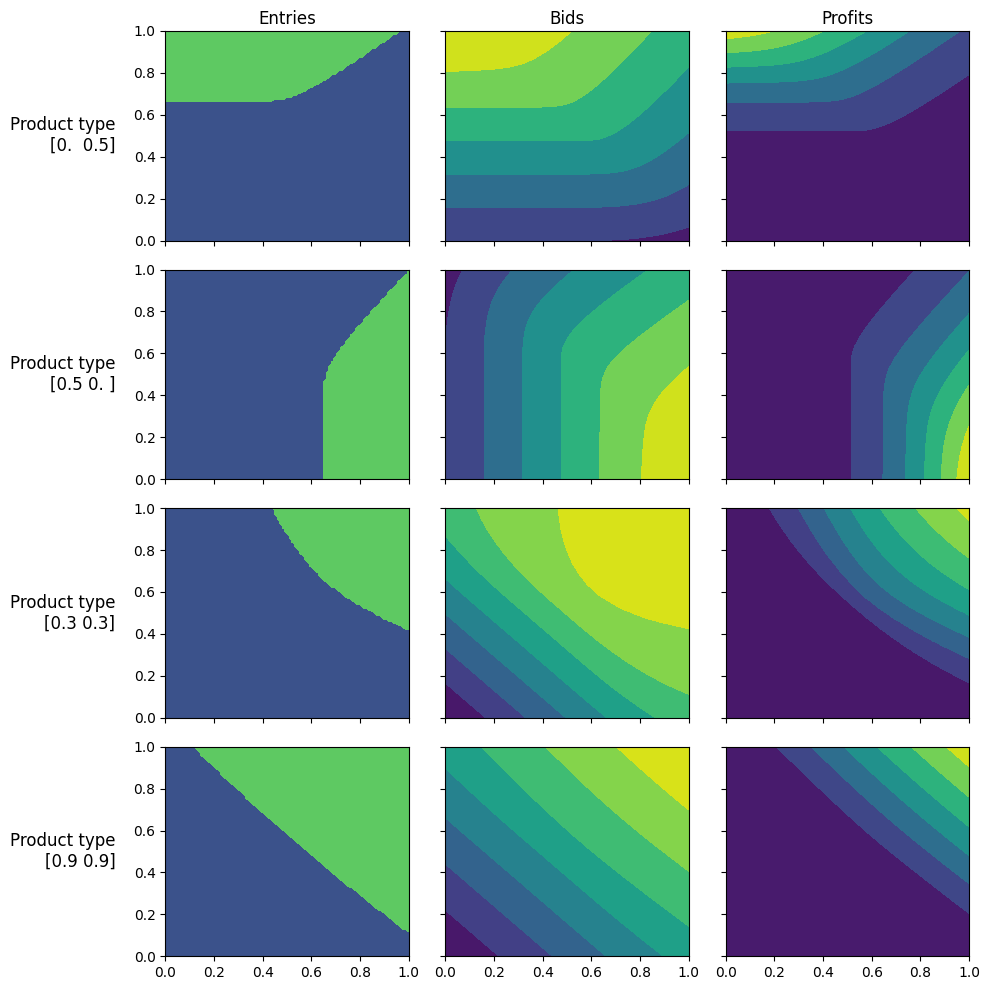

In [98]:
import matplotlib.pyplot as plt

def plot_contour(ax):
    # Generate data points
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)

    # Create a meshgrid from the data points
    Y, X = np.meshgrid(x, y)

    # Evaluate the function at each point in the meshgrid
    Z = V(cartesian_product(x, 2))  # Assuming V and cartesian_product are defined elsewhere
    Z = tf.reshape(Z, [100, 100])

    # Create a contour plot
    contour = ax.contour(X, Y, Z, cmap='viridis')

    # Add labels and a color bar
    ax.set_title('Continuation Value')
    ax.set_xlabel('beta1')
    ax.set_ylabel('beta2')
    plt.colorbar(contour, ax=ax, label='Continuation Value')

def plot_contour_entry(ax, x, entry_j_mat, beta_base):

    # Create a meshgrid from the data points
    Y, X = np.meshgrid(beta_base, beta_base)

    # Evaluate the function at each point in the meshgrid
    Z = entry_j_mat

    # Create a contour plot
    contour = ax.contourf(X, Y, Z, levels=[0, 0.5, 1], cmap='viridis')

    # # Add labels and a color bar
    # ax.set_title(f'Entry Strategy of Product {np.round(x.numpy(), 3)}')
    # ax.set_xlabel(r'$\beta_1$')
    # ax.set_ylabel(r'$\beta_2$')
    # plt.colorbar(contour, ax=ax, label='Value')

def plot_contour_profit(ax, x, profit_j_mat, beta_base):

    # Create a meshgrid from the data points
    Y, X = np.meshgrid(beta_base, beta_base)

    # Evaluate the function at each point in the meshgrid
    Z = profit_j_mat

    # Create a contour plot
    contour = ax.contourf(X, Y, Z, cmap='viridis')

    # # Add labels and a color bar
    # ax.set_title(f'Expected Profit from Bidding Product {np.round(x.numpy(), 3)}')
    # ax.set_xlabel(r'$\beta_1$')
    # ax.set_ylabel(r'$\beta_2$')
    # plt.colorbar(contour, ax=ax, label='Profit')

def plot_contour_bid(ax, x, bid_j_mat, beta_base):

    # Create a meshgrid from the data points
    Y, X = np.meshgrid(beta_base, beta_base)

    # Evaluate the function at each point in the meshgrid
    Z = bid_j_mat

    # Create a contour plot
    contour = ax.contourf(X, Y, Z, cmap='viridis')

    # # Add labels and a color bar
    # ax.set_title(f'Bids of Product {np.round(x.numpy(), 3)}')
    # ax.set_xlabel(r'$\beta_1$')
    # ax.set_ylabel(r'$\beta_2$')
    # plt.colorbar(contour, ax=ax, label='Profit')




fig, axes = plt.subplots(4, 3, figsize=(10,10), sharex=True, sharey=True)

js = [50, 5000, 3030, 9090]
xs = []
for j in js:
    xs.append(x_j[j])

cols = ['Entries', 'Bids', 'Profits']
rows = ['Product type\n{}'.format(np.round(x.numpy(), 1)) for x in xs]

for i, j in enumerate(js):

    x = x_j[j]

    entry_j_mat = tf.reshape(entry_ji[j,:], (numSIM_BETABASE, numSIM_BETABASE))
    profit_j_mat = tf.reshape(profit_ji[j,:], (numSIM_BETABASE, numSIM_BETABASE))
    bid_j_mat = tf.reshape(bid_ji[j,:], (numSIM_BETABASE, numSIM_BETABASE))

    plot_contour_entry(axes[i,0], x, entry_j_mat, beta_base)
    plot_contour_bid(axes[i,1], x, bid_j_mat, beta_base)
    plot_contour_profit(axes[i,2], x, profit_j_mat, beta_base)

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')


fig.tight_layout()


In [5]:
numSIM_BETABASE = 100
numSIM_J = 500
numSIM_RIVAL_I = 2000
numSIM_XBASE = 100

beta_base = np.linspace(BETA_MIN, BETA_MAX, numSIM_BETABASE)
beta_i = cartesian_product(beta_base, 2)

# x_j = generate_products(x_dist, J=numSIM_J)
x_base = np.linspace(X_MIN, X_MAX, numSIM_XBASE)
x_j = cartesian_product(x_base, 2)

beta_ri = generate_rivals_coef(beta_dist, R=numR, I=numSIM_RIVAL_I)
_, v_rival_max_rji = compute_rival_psuedo(beta_ri, x_j, V, delta)

profit_lst = []
for beta in beta_i:
    _, profit_j = value_1d(beta, x_j, v_rival_max_rji, V, prob_rival_num=prob_rival, kappa=kappa, delta=delta)
    profit_lst.append(profit_j)

profit_ji = tf.transpose(tf.stack(profit_lst))

entry_ji = tf.cast(profit_ji-kappa >= 0, tf.float64)

bid_ji = x_j @ tf.transpose(beta_i) - V(beta_i)
# assert profit_ji.shape == (numSIM_J, numSIM_BETABASE**2)
# assert entry_ji.shape == (numSIM_J, numSIM_BETABASE**2)

In [24]:
bid_ji = x_j @ tf.transpose(beta_i) - V(beta_i)

In [18]:
def result_1d(x, beta, x_dist, beta_dist, prob_rival_num, V):
    x_j=tf.expand_dims(x, axis=0)
    beta_ri = generate_rivals_coef(beta_dist, R=numR, I=1000)
    v_j = compute_buyers_psuedo(beta_i, x_j, V, delta)
    _, v_rival_max_rji = compute_rival_psuedo(beta_ri, x_j, V, delta)
    _, profit_j = value_1d(beta, x_j, v_rival_max_rji, V, prob_rival_num, kappa, delta)
    return profit_j[0]



product coefficient: tf.Tensor([0.         0.50505051], shape=(2,), dtype=float64)


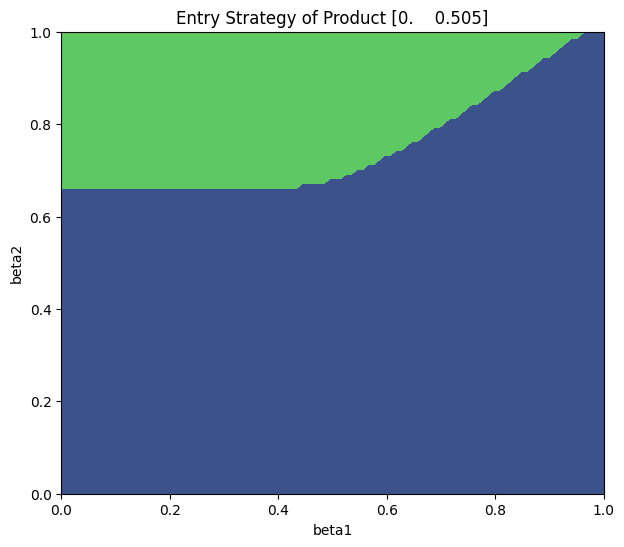

In [97]:
j = 50
entry_j_mat = tf.reshape(entry_ji[j,:], (numSIM_BETABASE, numSIM_BETABASE))
profit_j_mat = tf.reshape(profit_ji[j,:], (numSIM_BETABASE, numSIM_BETABASE))
bid_j_mat = tf.reshape(bid_ji[j,:], (numSIM_BETABASE, numSIM_BETABASE))

def plot_contour_entry(x, entry_j_mat, beta_base):

    # Create a meshgrid from the data points
    #    return order is Y, X; I have checked this multiple time.
    Y, X = np.meshgrid(beta_base, beta_base)


    # Evaluate the function at each point in the meshgrid
    Z = entry_j_mat  # Assuming V and cartesian_product are defined elsewhere

    # Create a contour plot
    plt.figure(figsize=(7, 6))
    contour = plt.contourf(X, Y, Z, levels=[0,0.5,1],cmap='viridis')

    # Add labels and a color bar
    plt.title(f'Entry Strategy of Product {np.round(x.numpy(), 3)}')
    plt.xlabel('beta1')
    plt.ylabel('beta2')
    #plt.colorbar(contour, label='Continuation Value')

    # Show the plot
    plt.show()


print('product coefficient:', x_j[j])
plot_contour_entry(x_j[j], entry_j_mat, beta_base)



product coefficient: tf.Tensor([0.88888889 0.88888889], shape=(2,), dtype=float64)


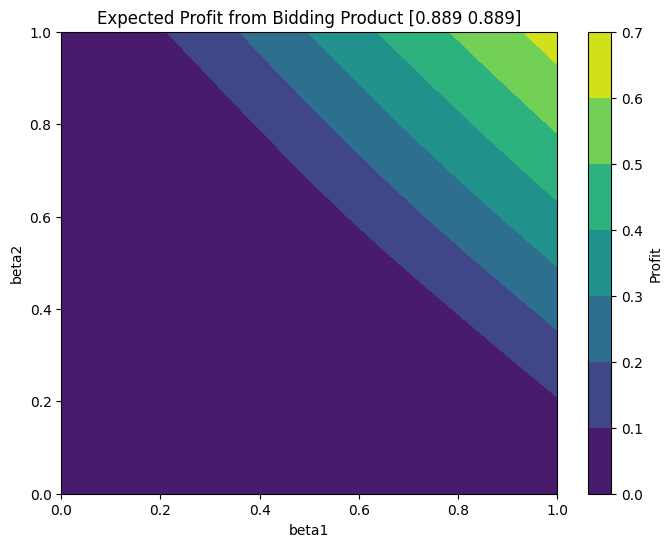

In [33]:
def plot_contour_profit(x, profit_j_mat, beta_base):

    # Create a meshgrid from the data points
    #    return order is Y, X; I have checked this multiple time.
    Y, X = np.meshgrid(beta_base, beta_base)


    # Evaluate the function at each point in the meshgrid
    Z = profit_j_mat  # Assuming V and cartesian_product are defined elsewhere

    # Create a contour plot
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X, Y, Z,cmap='viridis')

    # Add labels and a color bar
    plt.title(f'Expected Profit from Bidding Product {np.round(x.numpy(), 3)}')
    plt.xlabel('beta1')
    plt.ylabel('beta2')
    plt.colorbar(contour, label='Profit')

    # Show the plot
    plt.show()


print('product coefficient:', x_j[j])
plot_contour_profit(x_j[j], profit_j_mat, beta_base)

product coefficient: tf.Tensor([0.88888889 0.88888889], shape=(2,), dtype=float64)


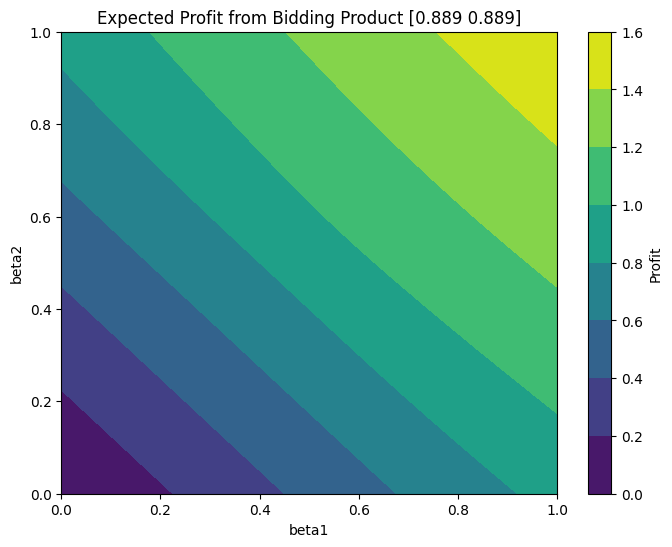

In [34]:
def plot_contour_profit(x, profit_j_mat, beta_base):

    # Create a meshgrid from the data points
    #    return order is Y, X; I have checked this multiple time.
    Y, X = np.meshgrid(beta_base, beta_base)


    # Evaluate the function at each point in the meshgrid
    Z = profit_j_mat  # Assuming V and cartesian_product are defined elsewhere

    # Create a contour plot
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X, Y, Z,cmap='viridis')

    # Add labels and a color bar
    plt.title(f'Expected Profit from Bidding Product {np.round(x.numpy(), 3)}')
    plt.xlabel('beta1')
    plt.ylabel('beta2')
    plt.colorbar(contour, label='Profit')

    # Show the plot
    plt.show()


print('product coefficient:', x_j[j])
plot_contour_profit(x_j[j], bid_j_mat, beta_base)

In [35]:
def simulate_data():
    """
    Simluate auction data observed by economists

    """
    return product_j, bids_ji

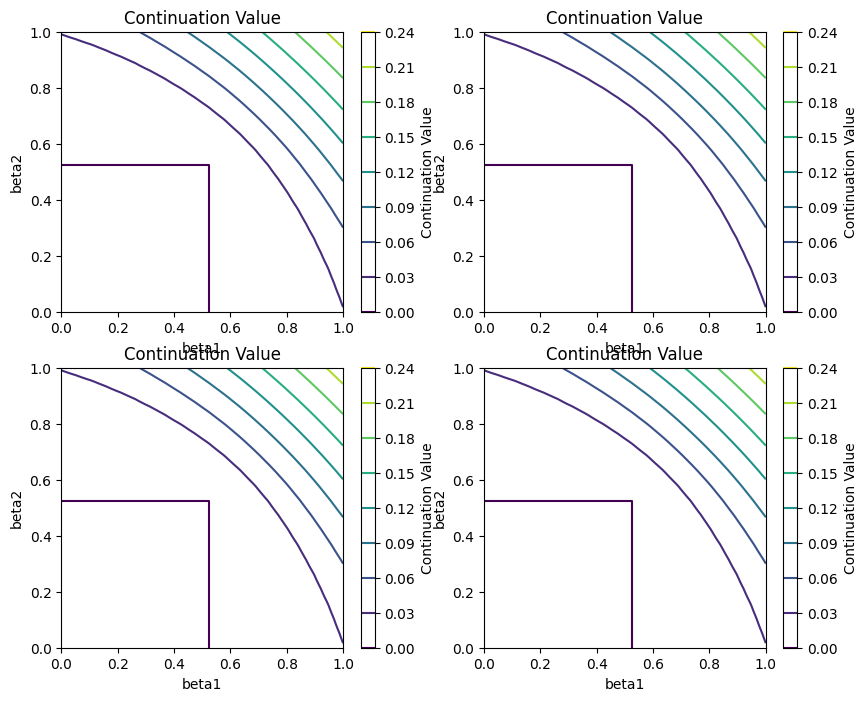

In [47]:
def plot_contour(ax):
    # Generate data points
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)

    # Create a meshgrid from the data points
    Y, X = np.meshgrid(x, y)

    # Evaluate the function at each point in the meshgrid
    Z = V(cartesian_product(x, 2))  # Assuming V and cartesian_product are defined elsewhere
    Z = tf.reshape(Z, [100, 100])

    # Create a contour plot
    contour = ax.contour(X, Y, Z, cmap='viridis')

    # Add labels and a color bar
    ax.set_title('Continuation Value')
    ax.set_xlabel('beta1')
    ax.set_ylabel('beta2')
    plt.colorbar(contour, ax=ax, label='Continuation Value')

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, axe in enumerate(axes):
    plot_contour(ax=axe)

In [24]:
# J distinct products (characterized by a K-dim vector) draw from x_dist
x_jk: Final  = x_dist.sample(numJ) # J*K matrix
# repeat J*K matrix to get R*J*K matrix. Each rival bidder faces the same product.
x: Final = tf.repeat(tf.expand_dims(x_jk, axis=0), repeats=numR, axis=0)

# get beta_rival, R*I*K
beta_rival = beta_dist.sample((numR, numI))

def init_V(beta_grids_1d):
    values = np.zeros([numGrid]*numK)
    # V_scipy is a callable, mapping beta to value (as numpy array)
    V_scipy = scipy.interpolate.RegularGridInterpolator((beta_grids_1d, beta_grids_1d), values)
    # V_scipy is a callable, mapping beta to value (as tensor)
    V = lambda x: tf.constant(V_scipy(x))
    return V, values

def generate_rivals(V):

    # get v_rival, R*J*I
    # v_rival(r,j,i) is the bid of a rival type beta_rival(r, i) for product x_(j)
    # V(beta) is R*I, repeat it along a new dimension to obtain a tensor of shape R×J×I
    v_beta = tf.repeat(tf.expand_dims(V(beta_rival), axis=1), repeats=numJ, axis=1)
    v_rival = tf.einsum('rik,rjk->rji', beta_rival, x) - delta * v_beta

    # get v_rival_tilde, R*J*I
    # v_rival_tilde(r,j,i) is the maximum bid of among r bidders
    v_rival_tilde_lst = []
    for i in range(numR):
        v_rival_tilde_lst.append(tf.reduce_max(v_rival[:i+1,:,:], axis=0))
    v_rival_tilde = tf.stack(v_rival_tilde_lst)

    return beta_rival, v_rival, v_rival_tilde

def update_value(pref_coef: tf.Tensor, product_coef: tf.Tensor, v_rival_tilde: tf.Tensor) -> tf.Tensor:

    assert product_coef.shape == (numJ, numK)
    assert pref_coef.shape == (numK)
    assert v_rival_tilde.shape == (numR, numJ, numI)

    # R*I*K
    beta_bar = tf.repeat(tf.expand_dims(pref_coef, axis=0), repeats=numI, axis=0)

    # J*I
    v_tilde_slice = product_coef @ tf.transpose(beta_bar) - delta * V(beta_bar)
    # R*J*I
    v_tilde = tf.repeat(tf.expand_dims(v_tilde_slice, axis=0), repeats=numR, axis=0)

    # profit if number of rivals is know.
    profit_rji = tf.nn.relu(v_tilde - v_rival_tilde)
    # profit weigted by the probability of rival number occurance.
    profit_rji_weighted = profit_rji * tf.expand_dims(tf.expand_dims(prob_rival, axis=1), axis=2)
    profit_ji = tf.reduce_sum(profit_rji_weighted, axis=0)
    # expected profit for each product if enter
    profit_j = tf.reduce_sum(profit_ji / numI, axis=0)

    # expected profit before knowing the product type, rival type, and number of rivals.
    value = tf.reduce_sum(tf.nn.relu(profit_j - kappa)) / numJ

    return value, profit_j

def update_V(V_old, beta_grids_1d):
    _, _, v_rival_tilde = generate_rivals(V_old)

    values_next = []
    for beta in beta_grids:
        value_at_beta, _ = update_value(pref_coef=beta, product_coef=x_jk, v_rival_tilde=v_rival_tilde)
        values_next.append(value_at_beta)

    # get values at grids to update V, NumPy type
    values = tf.reshape(tf.stack(values_next), [numGrid]*numK).numpy()
    # V_scipy is a callable, mapping beta to value (as numpy array)
    V_scipy = scipy.interpolate.RegularGridInterpolator((beta_grids_1d, beta_grids_1d), values)
    # V_scipy is a callable, mapping beta to value (as tensor)
    V_new = lambda x: tf.constant(V_scipy(x))
    return V_new, values





CPU times: user 33.3 ms, sys: 2.99 ms, total: 36.3 ms
Wall time: 35.1 ms


In [54]:
def generate_products(x_dist, J):
    """
    Randomly generate J products from distribution x_dist

    Inputs
    -------
    x_dist : tfp.distributions.Distribution
        product characteristics distribution
    J : int
        Number of products to generate

    Returns
    -------
    products : Tensor (J * numK)
        J random characteristics of numK dimension.
    """
    x_jk = x_dist.sample(J)
    return x_jk

def generate_buyers(beta_dist, I):
    beta_i = beta_dist.sample(I)
    return beta_i

def generate_rivals_coef(beta_dist, R, I):
    """
    Randomly generate (R*I) rivals from distribution beta_dist

    Returns
    -------
    rivals : Tensor (R * I * numK)
        J random characteristics of numK dimension.
    """
    return beta_dist.sample((R, I))

def compute_buyers_psuedo(beta_i, x_j, V, delta):
    """
    Compute buyer's psuedo types

    Returns
    -------
    v_ji : Tensor (J * I)
        (j,i)-element is the buyer i's psuedo valuation of product j
    """

    return x_j @ tf.transpose(beta_i) - delta * V(beta_i)

def compute_rival_psuedo(beta_ri, x_j, V, delta):
    """
    Compute rival's psuedo types

    Returns
    -------
    v_rival_rji : Tensor (R * J * I)
        (r,j,i)-element is the rival r's psuedo valuation in auction i of product j.
    v_rival_max_rji : Tensor (R * J * I)
        (r,j,i)-element is the highest psuedo type of among rival <= r in auction i of product j.
    """

    J = x_j.shape[0]
    R = beta_ri.shape[0]

    v_beta = tf.repeat(tf.expand_dims(V(beta_ri), axis=1), repeats=J, axis=1)
    v_rival_rji = tf.einsum('rik,rjk->rji', beta_ri, x) - delta * v_beta

    v_rival_max_lst = []
    for i in range(R):
        v_rival_max_lst.append(tf.reduce_max(v_rival_rji[:i+1,:,:], axis=0))
    v_rival_max_rji = tf.stack(v_rival_max_lst)

    return v_rival_rji, v_rival_max_rji

def value_1d(beta, x_j, v_rival_max_rji, V, prob_rival_num, kappa, delta):
    """
    Compute the continuation value.

    Inputs
    -------
    beta : Tensor (numK,)
        A buyer type to be evaluated
    x_j : Tensor (J, K)
        The product could be auction next period. (random, and follow some distribution)
    v_rival_max_rji :  Tensor (R, J, I)
        The possible highest rival in auction i for product j if the total number of rival is r
    prob_rival_num : Tensor (R)
        The probability of the number of rival == r+1

    Returns
    -------
    value : Tensor
        Value at beta.
    profit_j :  Tensor (J)
        The expected profit if the buyer enters an auction of product J
    """
    K = beta.shape[0]
    R, J, I  = v_rival_max_rji.shape
    assert x_j.shape == (J,K)
    assert prob_rival_num.shape[0] == R

    beta_i = tf.repeat(tf.expand_dims(beta, axis=0), repeats=I, axis=0)
    v_ji = compute_buyers_psuedo(beta_i, x_j, V, delta)
    v_rji = tf.repeat(tf.expand_dims(v_ji, axis=0), repeats=R, axis=0)


    profit_rji = tf.nn.relu(v_rji - v_rival_max_rji)
    # profit weigted by the probability of rival number occurance.
    profit_rji_weighted = profit_rji * tf.expand_dims(tf.expand_dims(prob_rival_num, axis=1), axis=2)
    profit_ji = tf.reduce_sum(profit_rji_weighted, axis=0)
    # expected profit for each product if enter
    profit_j = tf.reduce_sum(profit_ji / I, axis=0)

    # expected profit before knowing the product type, rival type, and number of rivals.
    value = tf.reduce_sum(tf.nn.relu(profit_j - kappa)) / J

    return value, profit_j

def value(beta_i, x_j, v_rival_max_rji, V, prob_rival_num, kappa, delta):

    I = beta_i.shape[0]

    values_lst = []
    for i in range(I):
        beta = beta_i[i,:]
        value_at_beta, _ = value_1d(beta, x_j, v_rival_max_rji, V, prob_rival_num, kappa, delta)
        values_lst.append(value_at_beta)

    # get values at grids to update V, NumPy type
    values = tf.reshape(tf.stack(values_lst), [int(I ** (1/numK))]*numK).numpy()

    return values


def update_V(V_old, x_j, beta_ri, beta_grids, prob_rival_num, kappa, delta):

    _, v_rival_max_rji = compute_rival_psuedo(beta_ri, x_j, V, delta)

    values = value(beta_grids, x_j, v_rival_max_rji, V_old, prob_rival_num, kappa, delta)

    V_scipy = scipy.interpolate.RegularGridInterpolator((beta_grids_1d, beta_grids_1d), values)
    V_new = lambda x: tf.constant(V_scipy(x))

    return V_new, values


def init_V(beta_grids_1d):
    num_grid = beta_grids_1d.shape[0]
    assert num_grid == numGrid

    values = np.zeros([numGrid]*numK)
    # V_scipy is a callable, mapping beta to value (as numpy array)
    V_scipy = scipy.interpolate.RegularGridInterpolator((beta_grids_1d, beta_grids_1d), values)
    # V_scipy is a callable, mapping beta to value (as tensor)
    V = lambda x: tf.constant(V_scipy(x))
    return V, values


def VFI(x_dist, beta_dist, grids=beta_grids, prob_rival_num=prob_rival, R=numR, I=numI, J=numJ, max_iter_ = MAX_VALUE_ITER, tol_ = VALUE_TOLER):

    x_j = generate_products(x_dist, J)

    beta_ri = generate_rivals_coef(beta_dist, R, I)

    V, values = init_V(beta_grids_1d)

    for i in range(MAX_VALUE_ITER):
        V_new, values_new = update_V(V, x_j, beta_ri, beta_grids, prob_rival_num, kappa, delta)
        distance = tf.norm(values_new - values, ord='fro', axis=(0, 1))
        print('Frobenius distance between two iteration:',distance.numpy())
        V, values = V_new, values_new
        if distance < VALUE_TOLER:
            break

    return V, values

In [55]:
VFI(x_dist, beta_dist)

Frobenius distance between two iteration: 3.8680807959663466
Frobenius distance between two iteration: 1.840814881970044
Frobenius distance between two iteration: 0.8262506786415355
Frobenius distance between two iteration: 0.4015817654121641
Frobenius distance between two iteration: 0.193789512460717
Frobenius distance between two iteration: 0.09587476996033456
Frobenius distance between two iteration: 0.047578276390391465
Frobenius distance between two iteration: 0.023866486379221376
Frobenius distance between two iteration: 0.012024392620419159
Frobenius distance between two iteration: 0.006094579434133365
Frobenius distance between two iteration: 0.003100994555953401
Frobenius distance between two iteration: 0.0015841478152383616
Frobenius distance between two iteration: 0.0008118145069730174


(<function __main__.update_V.<locals>.<lambda>(x)>,
 array([[1.00125740e-05, 9.20154052e-05, 5.11446579e-04, 1.40484303e-03,
         2.88909209e-03, 4.99518652e-03, 7.84809690e-03, 1.13860475e-02,
         1.56048296e-02, 2.05494005e-02, 2.62989282e-02, 3.27995873e-02,
         4.00101481e-02, 4.78816639e-02, 5.63569790e-02, 6.54278603e-02,
         7.51001512e-02, 8.53672391e-02, 9.61928231e-02, 1.07536934e-01],
        [1.00127750e-04, 4.12008662e-04, 1.18242910e-03, 2.41282302e-03,
         4.29606364e-03, 6.95303414e-03, 1.02855252e-02, 1.42733353e-02,
         1.89426400e-02, 2.43879627e-02, 3.06368655e-02, 3.76377432e-02,
         4.53231771e-02, 5.36293690e-02, 6.25208904e-02, 7.20088243e-02,
         8.20978140e-02, 9.27681551e-02, 1.03975739e-01, 1.15675618e-01],
        [5.18137220e-04, 1.16999981e-03, 2.23624498e-03, 3.94674084e-03,
         6.40476854e-03, 9.54052809e-03, 1.33289298e-02, 1.77410386e-02,
         2.28750343e-02, 2.88266488e-02, 3.55833809e-02, 4.30648545e-0

In [25]:
-%%time
V, values = View = init_V(beta_grids_1d)
for _ in range(MAX_VALUE_ITER):
    V_new, values_new = update_V(V, beta_grids_1d)
    distance = tf.norm(values_new - values, ord='fro', axis=(0, 1))
    print('Frobenius distance between two iteration:',distance.numpy())
    V, values = V_new, values_new
    if distance < VALUE_TOLER:
        break

Frobenius distance between two iteration: 2.388553620763537
Frobenius distance between two iteration: 1.2606625014499349
Frobenius distance between two iteration: 0.741425188300566
Frobenius distance between two iteration: 0.47691399056420636
Frobenius distance between two iteration: 0.3022834651081934
Frobenius distance between two iteration: 0.19778928976312957
Frobenius distance between two iteration: 0.1285433048611764
Frobenius distance between two iteration: 0.08474388680435806
Frobenius distance between two iteration: 0.05574510697977889
Frobenius distance between two iteration: 0.03693632157282482
Frobenius distance between two iteration: 0.024468446005824554
Frobenius distance between two iteration: 0.016274614328608234
Frobenius distance between two iteration: 0.010830891193073313
Frobenius distance between two iteration: 0.007225855364014548
Frobenius distance between two iteration: 0.0048247495198800346
Frobenius distance between two iteration: 0.0032268499051804345
Frobeni

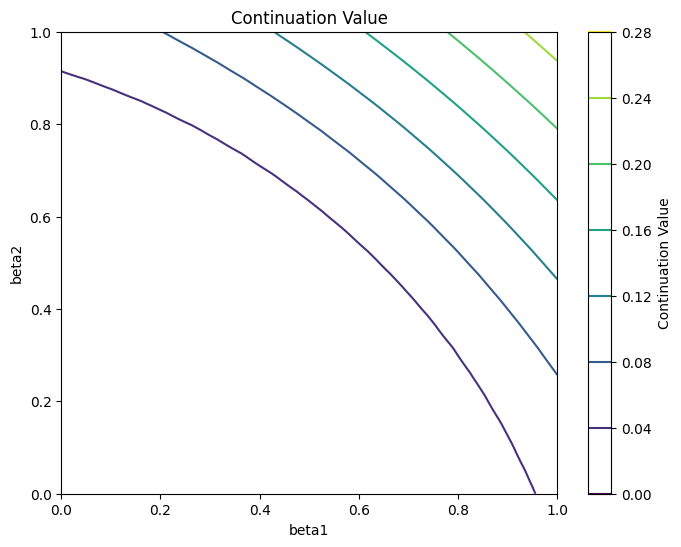

In [26]:
import matplotlib.pyplot as plt

def plot_contour():
    # Generate data points
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)

    # Create a meshgrid from the data points
    X, Y = np.meshgrid(x, y)

    # Evaluate the function at each point in the meshgrid
    Z = V(cartesian_product(x, 2))  # Assuming V and cartesian_product are defined elsewhere
    Z = tf.reshape(Z, [100, 100])

    # Create a contour plot
    plt.figure(figsize=(8, 6))
    contour = plt.contour(X, Y, Z, cmap='viridis')

    # Add labels and a color bar
    plt.title('Continuation Value')
    plt.xlabel('beta1')
    plt.ylabel('beta2')
    plt.colorbar(contour, label='Continuation Value')

    # Show the plot
    plt.show()

plot_contour()

In [31]:
# def strategy(product_coef, beta, V):
#     """
#     The entry and bidding strategy when the product is x
#     """

#     assert product_coef.shape == (numK)
#     assert beta.shape[1] == numK

#     numbeta = beta.shape[0]
#     _, _, v_rival_tilde = generate_rivals(V)
#     x = tf.expand_dims(product_coef, axis=0)
#     bids = x @ tf.transpose(beta) - V(beta))
#     entry

#     return 0
#     #return entry, bids

def strategy(V, pref_coef):

    # if pref_coef is a 1d vector, expand to 2d
    if tf.rank(pref_coef).numpy() == 1:
        pref_coef = tf.expand_dims(pref_coef, axis=0)

    _, _, v_rival_tilde = generate_rivals(V) # R*J*I

    profits_j = []
    for i in range(pref_coef.shape[0]):
        beta = pref_coef[i,:]
        print(beta)
        _, profit_j= update_value(pref_coef=beta, product_coef=x_jk, v_rival_tilde=v_rival_tilde)
        profits_j.append(profit_j)

    value = tf.stack(profits_j) # J*I

    print(value)
    return 0

pref_coef = tf.constant([[0.3, 0.8], [0.5, 0.5]], dtype=tf.float64)
strategy(V, pref_coef)


tf.Tensor([0.3 0.8], shape=(2,), dtype=float64)
tf.Tensor([0.5 0.5], shape=(2,), dtype=float64)
tf.Tensor(
[[0.00038943 0.04892008 0.05422281 ... 0.02889398 0.01195602 0.04870015]
 [0.01687887 0.00959242 0.0062356  ... 0.01357218 0.01073832 0.01828543]], shape=(2, 1000), dtype=float64)


0

<tf.Tensor: shape=(10000,), dtype=float64, numpy=
array([1.10543683e-05, 1.19025207e-05, 1.27506731e-05, ...,
       2.57338731e-01, 2.60133848e-01, 2.62928965e-01])>

In [ ]:
#################
# scipy.interpolate.LinearNDInterpolator is not suitable.
# It is used for 'unregular', usually sparse, grid.
#################

# beta_grids_1d = tf.linspace(BETA_MIN, BETA_MAX, numGrid)
# beta_grids = cartesian_product(beta_grids_1d, numK)
# values_init = beta_grids @ np.array([1]*numK)
# # V_scipy is a callable, mapping beta to value (as numpy array)
# V_scipy = scipy.interpolate.LinearNDInterpolator(beta_grids, values_init)
# # V_scipy is a callable, mapping beta to value (as tensor)
# V = lambda x: tf.constant(V_scipy(x))


def init_V(beta_grids_1d):
    values = np.zeros([numGrid]*numK)
    # V_scipy is a callable, mapping beta to value (as numpy array)
    V_scipy = scipy.interpolate.RegularGridInterpolator((beta_grids_1d, beta_grids_1d), values)
    # V_scipy is a callable, mapping beta to value (as tensor)
    V = lambda x: tf.constant(V_scipy(x))
    return V


# beta = beta_dist.sample(numI)
# x = x_dist.sample(numJ)

# V = init_V(beta_grids_1d)
# v_tilde = x @ tf.transpose(beta) - delta * V(beta)

# v_tilde


tf.Tensor(1.303619288871049, shape=(), dtype=float64)
tf.Tensor(0.7033526372984477, shape=(), dtype=float64)
tf.Tensor(0.4197419401749958, shape=(), dtype=float64)
tf.Tensor(0.27305611955030773, shape=(), dtype=float64)
tf.Tensor(0.17535808839059044, shape=(), dtype=float64)
tf.Tensor(0.11615896043097694, shape=(), dtype=float64)
tf.Tensor(0.07645139628564232, shape=(), dtype=float64)
tf.Tensor(0.05103295925475001, shape=(), dtype=float64)
tf.Tensor(0.03399070048279049, shape=(), dtype=float64)
tf.Tensor(0.022803326798286352, shape=(), dtype=float64)
tf.Tensor(0.015293999952627542, shape=(), dtype=float64)
tf.Tensor(0.010298844962736673, shape=(), dtype=float64)
tf.Tensor(0.006938762941404664, shape=(), dtype=float64)
tf.Tensor(0.0046864322856062625, shape=(), dtype=float64)
tf.Tensor(0.003167692202739157, shape=(), dtype=float64)
tf.Tensor(0.0021446553345925634, shape=(), dtype=float64)
tf.Tensor(0.0014532100501128207, shape=(), dtype=float64)
tf.Tensor(0.000985863135126268, shape=(),

In [ ]:
# get x, R*J*K
x_jk = x_dist.sample(numJ) # J*K matrix
# repeat J*K matrix to get R*J*K matrix. Each rival bidder faces the same product.
x = tf.repeat(tf.expand_dims(x_jk, axis=0), repeats=numR, axis=0)

# get beta_rival, R*I*K
beta_rival = beta_dist.sample((numR, numI))

# get v_rival, R*J*I
# v_rival(r,j,i) is the bid of a rival type beta_rival(r, i) for product x_(j)
# V(beta) is R*I, repeat it along a new dimension to obtain a tensor of shape R×J×I
v_beta = tf.repeat(tf.expand_dims(V(beta_rival), axis=1), repeats=numJ, axis=1)
v_rival = tf.einsum('rik,rjk->rji', beta_rival, x) - delta * v_beta

# get v_rival_tilde, R*J*I
# v_rival_tilde(r,j,i) is the maximum bid of among r bidders
v_rival_tilde_lst = []
for i in range(numR):
    v_rival_tilde_lst.append(tf.reduce_max(v_rival[:i+1,:,:], axis=0))
v_rival_tilde = tf.stack(v_rival_tilde_lst)


In [ ]:
# I*K
beta_bar_slice = tf.constant([0.8, 0.8], dtype=tf.float64)
# R*I*K
beta_bar = tf.repeat(tf.expand_dims(beta_bar_slice, axis=0), repeats=numI, axis=0)

# J*I
v_tilde_slice = x_jk @ tf.transpose(beta_bar) - delta * V(beta_bar)
# R*J*I
v_tilde = tf.repeat(tf.expand_dims(v_tilde_slice, axis=0), repeats=numR, axis=0)

# profit if number of rivals is know.
profit_rji = tf.nn.relu(v_tilde - v_rival_tilde)
# profit weigted by the probability of rival number occurance.
profit_rji_weighted = profit_rji * tf.expand_dims(tf.expand_dims(prob_rival, axis=1), axis=2)
# profit before knowing the number of rivals
profit_ji = tf.reduce_sum(profit_rji_weighted, axis=0)

# value of type beta_bar_slice
profit = tf.reduce_sum(tf.nn.relu(profit_ji - kappa)) / (numI*numJ)

profit


<tf.Tensor: shape=(), dtype=float64, numpy=0.23365695066238706>

In [ ]:
def update_value(pref_coef: tf.Tensor, product_coef: tf.Tensor) -> tf.Tensor:

    assert product_coef.shape == (numJ, numK)
    assert pref_coef.shape == (numK)

    # R*I*K
    beta_bar = tf.repeat(tf.expand_dims(pref_coef, axis=0), repeats=numI, axis=0)

    # J*I
    v_tilde_slice = product_coef @ tf.transpose(beta_bar) - delta * V(beta_bar)
    # R*J*I
    v_tilde = tf.repeat(tf.expand_dims(v_tilde_slice, axis=0), repeats=numR, axis=0)

    # profit if number of rivals is know.
    profit_rji = tf.nn.relu(v_tilde - v_rival_tilde)
    # profit weigted by the probability of rival number occurance.
    profit_rji_weighted = profit_rji * tf.expand_dims(tf.expand_dims(prob_rival, axis=1), axis=2)
    # profit before knowing the number of rivals
    profit_ji = tf.reduce_sum(profit_rji_weighted, axis=0)

    # value of type beta_bar_slice
    profit = tf.reduce_sum(tf.nn.relu(profit_ji - kappa)) / (numI*numJ)

    return profit


def update_V(beta_grids_1d):
    V_next = []
    # counter = 0
    for beta in beta_grids:
        V_next.append(update_value(pref_coef=beta, product_coef=x_jk))
        # if counter % 1000 == 0:
        #     print(counter)
        # counter = counter + 1


    # get values at grids to update V, NumPy type
    values = tf.reshape(tf.stack(V_next), [numGrid]*numK).numpy()
    # V_scipy is a callable, mapping beta to value (as numpy array)
    V_scipy = scipy.interpolate.RegularGridInterpolator((beta_grids_1d, beta_grids_1d), values)
    # V_scipy is a callable, mapping beta to value (as tensor)
    V = lambda x: tf.constant(V_scipy(x))
    return V, values




X, Y = np.meshgrid(beta_grids_1d, beta_grids_1d)  # 2D grid for interpolation

plt.pcolormesh(X, Y, Z, shading='gouraud')
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

transformed_distribution.prob([0.5,0.5])


In [ ]:
V_next = []
# counter = 0
for beta in beta_grids:
    V_next.append(update_value(pref_coef=beta, product_coef=x_jk))
    # if counter % 1000 == 0:
    #     print(counter)
    # counter = counter + 1


# get values at grids to update V, NumPy type
values = tf.reshape(tf.stack(V_next), [numGrid]*numK).numpy()
# V_scipy is a callable, mapping beta to value (as numpy array)
V_scipy = scipy.interpolate.RegularGridInterpolator((beta_grids_1d, beta_grids_1d), values)
# V_scipy is a callable, mapping beta to value (as tensor)
V = lambda x: tf.constant(V_scipy(x))


<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.01693446])>

In [ ]:
import tensorflow as tf

# Example tensor of shape R x J x I
tensor_rji = profit_rji

# Example vector of shape R
vector_r = prob_rival

# Perform element-wise multiplication
result_tensor = tensor_rji * tf.expand_dims(tf.expand_dims(vector_r, axis=1), axis=2)

# Sum along the R dimension to get a J x I tensor
result_tensor_ji = tf.reduce_sum(result_tensor, axis=0)

# Print the result
print("Original Tensor (R x J x I):")
print(tensor_rji)
print("\nVector (R):")
print(vector_r)
print("\nResult Tensor (J x I):")
print(result_tensor_ji)


InvalidArgumentError: ignored

In [ ]:
import tensorflow as tf

# Example tensor of shape R x I
tensor_ri = tf.constant([[1, 2],
                         [3, 4],
                         [5, 6]])

# Parameters
R = tf.shape(tensor_ri)[0]
I = tf.shape(tensor_ri)[1]
J = 5  # Number of repetitions along the new dimension

# Repeat the tensor along a new dimension
tensor_rji = tf.repeat(tf.expand_dims(tensor_ri, axis=1), repeats=J, axis=1)

# Print the result
print("Original Tensor (R x I):")
print(tensor_ri)
print("\nRepeated Tensor (R x J x I):")
print(tensor_rji)

Original Tensor (R x I):
tf.Tensor(
[[1 2]
 [3 4]
 [5 6]], shape=(3, 2), dtype=int32)

Repeated Tensor (R x J x I):
tf.Tensor(
[[[1 2]
  [1 2]
  [1 2]
  [1 2]
  [1 2]]

 [[3 4]
  [3 4]
  [3 4]
  [3 4]
  [3 4]]

 [[5 6]
  [5 6]
  [5 6]
  [5 6]
  [5 6]]], shape=(3, 5, 2), dtype=int32)


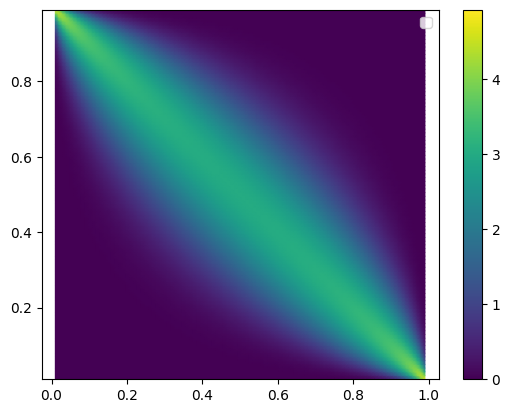

<tf.Tensor: shape=(), dtype=float64, numpy=3.015113445777636>

In [ ]:
# Create a 2-dimensional normal distribution
mu = tf.constant([0, 0], dtype=tf.float64)
cov = tf.constant([[0.6, -0.5], [-0.5, 0.6]], dtype=tf.float64)
scale = tf.linalg.cholesky(cov)

normal_distribution = tfd.MultivariateNormalTriL(
    loc=mu,
    scale_tril=scale)

# Create a normal CDF bijector
normal_cdf_bijector = tfp.bijectors.NormalCDF()

# Transform the distribution using the bijector
transformed_distribution = tfp.distributions.TransformedDistribution(
    distribution=normal_distribution,
    bijector=normal_cdf_bijector
)

transformed_distribution.prob([0.09,0.01])

x = np.linspace(0.01, 0.99, 100)
X, Y = np.meshgrid(x, x)  # 2D grid for interpolation
Z = transformed_distribution.prob(cartesian_product(x, 2))
Z = tf.reshape(Z, (100,100))
plt.pcolormesh(X, Y, Z, shading='gouraud')
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

transformed_distribution.prob([0.5,0.5])

In [ ]:
tf.reshape(
    Z, 1000,1000), name=None
)

<tf.Tensor: shape=(1000, 1000), dtype=float64, numpy=
array([[5.15363290e-03, 5.59384560e-03, 6.03225442e-03, ...,
        6.64792877e+00, 6.82236972e+00, 7.01328247e+00],
       [5.59384560e-03, 6.06661205e-03, 6.53704114e-03, ...,
        6.47732523e+00, 6.64217657e+00, 6.82236972e+00],
       [6.03225442e-03, 6.53704114e-03, 7.03893687e-03, ...,
        6.32106323e+00, 6.47732523e+00, 6.64792877e+00],
       ...,
       [6.64792877e+00, 6.47732523e+00, 6.32106323e+00, ...,
        7.03893687e-03, 6.53704114e-03, 6.03225442e-03],
       [6.82236972e+00, 6.64217657e+00, 6.47732523e+00, ...,
        6.53704114e-03, 6.06661205e-03, 5.59384560e-03],
       [7.01328247e+00, 6.82236972e+00, 6.64792877e+00, ...,
        6.03225442e-03, 5.59384560e-03, 5.15363290e-03]])>

In [ ]:
X

array([[0.01, 0.03, 0.05, ..., 0.95, 0.97, 0.99],
       [0.01, 0.03, 0.05, ..., 0.95, 0.97, 0.99],
       [0.01, 0.03, 0.05, ..., 0.95, 0.97, 0.99],
       ...,
       [0.01, 0.03, 0.05, ..., 0.95, 0.97, 0.99],
       [0.01, 0.03, 0.05, ..., 0.95, 0.97, 0.99],
       [0.01, 0.03, 0.05, ..., 0.95, 0.97, 0.99]])

In [ ]:
transformed_distribution.prob([[0.1,0.1], [0.1,0.9]])

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.22345765, 1.9963074 ])>

In [ ]:
cartesian_product(x, 2)

array([[0.      , 0.      ],
       [0.      , 0.001001],
       [0.      , 0.002002],
       ...,
       [1.      , 0.997998],
       [1.      , 0.998999],
       [1.      , 1.      ]])

In [ ]:
%%time
V(tf.constant(beta_grids))

CPU times: user 676 ms, sys: 4.99 ms, total: 681 ms
Wall time: 757 ms


array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
%%time
V(beta_grids)

CPU times: user 644 ms, sys: 1.87 ms, total: 646 ms
Wall time: 677 ms


array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
%%time
V(tf_beta_grids)

CPU times: user 665 ms, sys: 1.55 ms, total: 667 ms
Wall time: 672 ms


array([0., 0., 0., ..., 0., 0., 0.])

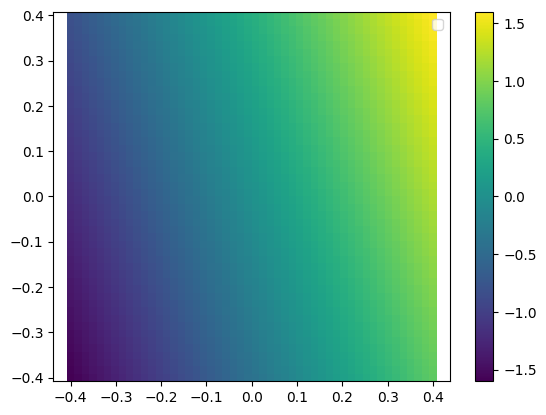

In [ ]:
import scipy

from scipy.interpolate import LinearNDInterpolator
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0.1, 0.9, 10)-0.5
points = cartesian_product(x, ndim=2)
values = points @ [3, 1]
X = np.linspace(min(x), max(x))
Y = np.linspace(min(x), max(x))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = scipy.interpolate.LinearNDInterpolator(points, values)
Z = interp(X, Y)
plt.pcolormesh(X, Y, Z, shading='auto')
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

In [ ]:
Z

array([[-1.6       , -1.55102041, -1.50204082, ...,  0.70204082,
         0.75102041,  0.8       ],
       [-1.58367347, -1.53469388, -1.48571429, ...,  0.71836735,
         0.76734694,  0.81632653],
       [-1.56734694, -1.51836735, -1.46938776, ...,  0.73469388,
         0.78367347,  0.83265306],
       ...,
       [-0.83265306, -0.78367347, -0.73469388, ...,  1.46938776,
         1.51836735,  1.56734694],
       [-0.81632653, -0.76734694, -0.71836735, ...,  1.48571429,
         1.53469388,  1.58367347],
       [-0.8       , -0.75102041, -0.70204082, ...,  1.50204082,
         1.55102041,  1.6       ]])

In [ ]:
Y

array([[-0.4       , -0.4       , -0.4       , ..., -0.4       ,
        -0.4       , -0.4       ],
       [-0.38367347, -0.38367347, -0.38367347, ..., -0.38367347,
        -0.38367347, -0.38367347],
       [-0.36734694, -0.36734694, -0.36734694, ..., -0.36734694,
        -0.36734694, -0.36734694],
       ...,
       [ 0.36734694,  0.36734694,  0.36734694, ...,  0.36734694,
         0.36734694,  0.36734694],
       [ 0.38367347,  0.38367347,  0.38367347, ...,  0.38367347,
         0.38367347,  0.38367347],
       [ 0.4       ,  0.4       ,  0.4       , ...,  0.4       ,
         0.4       ,  0.4       ]])

In [ ]:
x = rng.random(10) - 0.5
y = rng.random(10) - 0.5

In [ ]:
x

array([-0.25080465, -0.380831  , -0.41672725,  0.04978269, -0.11794582,
       -0.32948162,  0.24765411, -0.44566919, -0.12455026, -0.25880594])

array([0.1])